In [1]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings

/Users/eason/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
# download data from yfinance, find the ticker pair that have high correlation:
start = '2015-01-01'
end = '2023-01-01'
name1 = 'BAC'
name2 = 'JPM'

stock1 = yf.Ticker(name1)
data1 = stock1.history(interval='1d',start=start,end=end)
stock2 = yf.Ticker(name2)
data2 = stock2.history(interval='1d',start=start,end=end)

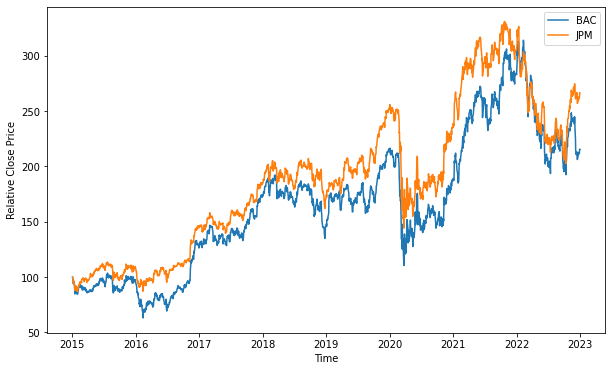

In [9]:
# standardize stock price as percentage relative to starting date close price:
s1rc = data1['Close']/data1['Close'][0] * 100
s2rc = data2['Close']/data2['Close'][0] * 100
plt.figure(figsize=(10,6))
plt.plot(s1rc,label=name1)
plt.plot(s2rc,label=name2)
plt.xlabel('Time')
plt.ylabel('Relative Close Price')
plt.legend()
plt.show()

In [15]:
# Cointegration test:
X = np.log(data1['Close'])
Y = np.log(data2['Close'])
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.params)
alpha = results.params.values[0]
beta = results.params.values[1]
errors = Y - (alpha+beta*X['Close']) # spreads

const    1.523804
Close    0.933621
dtype: float64


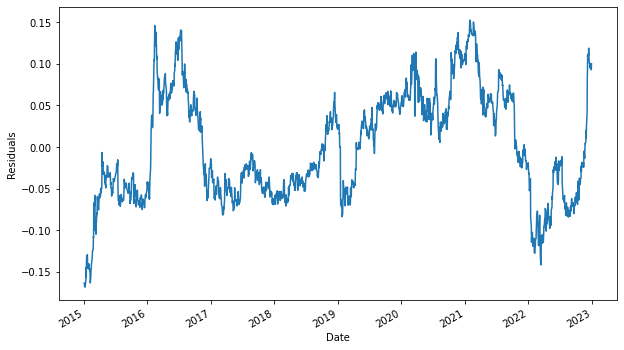

In [18]:
plt.figure(figsize=(10,6))
errors.plot()
plt.ylabel('Residuals')
plt.show()

In [21]:
# Dickey Fuller Test:
dftest = adfuller(errors, maxlag=1)
print(dftest)
dickey = pd.Series(dftest[0:4],index=['Test Statistic','p-value','# of lags','# of observations'])
critical_values = pd.Series(dftest[4].values(),index=dftest[4].keys())
print(dickey)
print(critical_values)

(-3.108536304575811, 0.025927879580499014, 1, 2012, {'1%': -3.433604305449515, '5%': -2.8629775816425003, '10%': -2.5675353062242845}, -13923.26672630262)
Test Statistic         -3.108536
p-value                 0.025928
# of lags               1.000000
# of observations    2012.000000
dtype: float64
1%    -3.433604
5%    -2.862978
10%   -2.567535
dtype: float64


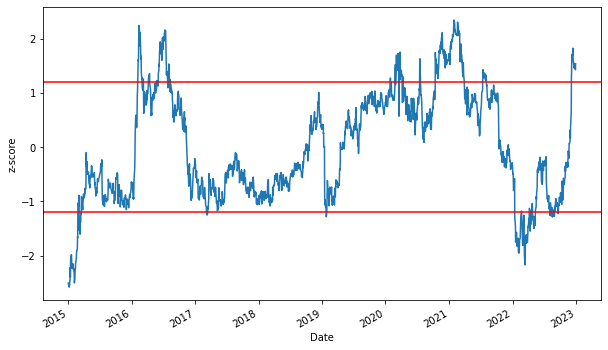

In [23]:
# generate Z-score and pair trading signal
z_score  = (errors - np.mean(errors))/np.std(errors)
plt.figure(figsize=(10,6))
z_score.plot(label='z-score')
plt.ylabel('z-score')
plt.axhline(y=1.2,color='r')
plt.axhline(y=-1.2,color='r')
plt.show()

In [29]:
# pair trading strategy:
signal_entry = 1.2
signal_exit = -1.2

df = pd.DataFrame()
df[name2] = data2['Close']
df[name1] = data1['Close']
df['short_signal'] = (z_score>signal_entry) & (z_score.shift(1)<signal_entry)
df['short_exit'] = (z_score<signal_exit) & (z_score.shift(1)>signal_exit)
df['long_signal'] = (z_score<-signal_entry) & (z_score.shift(1)>-signal_entry)
df['long_exit'] = (z_score>-signal_exit) & (z_score.shift(1)<-signal_exit)

In [35]:
# backtesting:
spread_side = None
counter = -1
backtest_result = []
indicator = 0

for time, signal_stock in df.iterrows():
    counter+=1
    stock2, stock1, short_signal, short_exit, long_signal, long_exit = signal_stock
    
    if spread_side == None:
        return_stock2 = 0
        return_stock1 = 0
        backtest_result.append([time,return_stock2,return_stock1,spread_side])
        if short_signal == True:
            spread_side = 'short'
        elif long_signal == True:
            spread_side = 'long'  
            
    elif spread_side == 'long':
        return_stock2 = df[name2][counter] / df[name2][counter-1] -1
        return_stock1 = df[name1][counter] / df[name1][counter-1] -1
        backtest_result.append([time,return_stock2,-return_stock1,spread_side])
        if long_exit == True:
            spread_side = None
        
    elif spread_side == 'short':
        return_stock2 = df[name2][counter] / df[name2][counter-1] -1
        return_stock1 = df[name1][counter] / df[name1][counter-1] -1
        backtest_result.append([time,-return_stock2,return_stock1,spread_side])
        if short_exit == True:
            spread_side = None

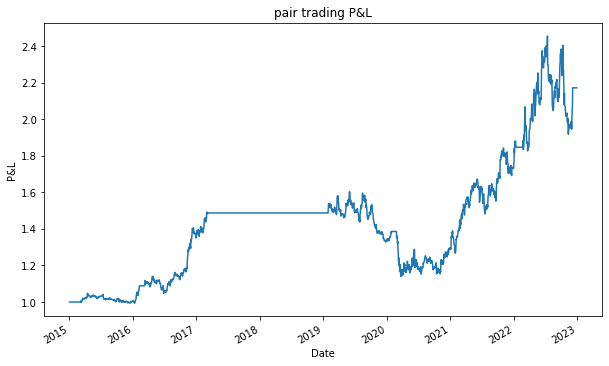

In [39]:
# cumulate backtestign result:
backtest = pd.DataFrame(backtest_result)
backtest.columns = ['Date',name2,name1,'side']
backtest[name2+' PL'] = np.cumprod(backtest[name2]+1.)
backtest[name1+' PL'] = np.cumprod(backtest[name1]+1.)
backtest['Total PL'] = (backtest[name2+' PL']+backtest[name1+' PL'])/2
backtest.index = backtest['Date']
plt.figure(figsize=(10,6))
backtest['Total PL'].plot()
plt.title('pair trading P&L')
plt.ylabel('P&L')
plt.show()

In [ ]:
# https://github.com/KidQuant/Pairs-Trading-With-Python/blob/master/PairsTrading.ipynb
# https://blog.quantinsti.com/pairs-trading-basics/